# Testing unfolding -- folded raw spectra of 164Dy
Procedure:
- Act as if the unfolded spectrum was the raw spectrum of 162Dy [sic, but next lines].
- Generate the apparent raw spectrum by folding the unfolded spectrum
- Unfold the apparent raw spectrum and compare to the unfolded (/"true") spectrum 
- Check effect of efficiency normalization

In [1]:
%matplotlib notebook

In [2]:
import ompy as om
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


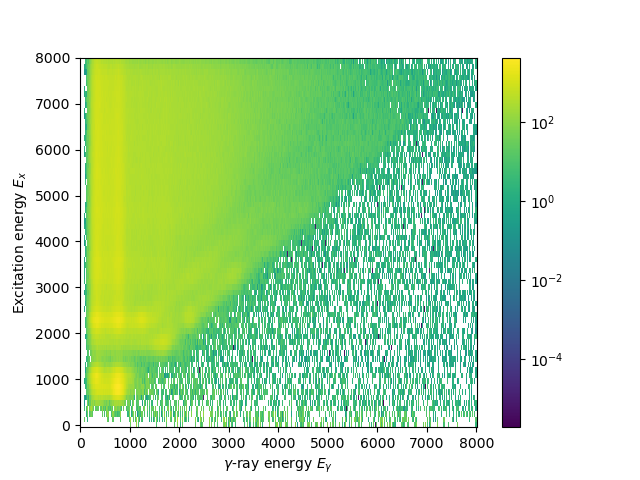

(<matplotlib.collections.QuadMesh at 0x7f80450719e8>,
 <Figure size 640x480 with 2 Axes>)

In [3]:
raw = om.example_raw("dy164")
raw.cut("Eg", 0, 8e3)
raw.cut("Ex", 0, 8e3)
raw.remove_negative() # for simplicity
raw.plot()

In [4]:
mock_true = raw.copy()

In [5]:
# fold with R from ompy
folderpath = "/home/fabiobz/Desktop/Masterthesis/misc/ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)
fwhm_abs=30 # (30/1330 = 2.25%) # Experimental relative FWHM at 1.33 MeV
R_view, R_tab_view = response.interpolate(mock_true.Eg, fwhm_abs=fwhm_abs, return_table=True)
                                     
# create R for unfolding (Magne suggests fwhm_abs' = fwhm_abs/10)
R_unf, R_tab_unf = response.interpolate(mock_true.Eg, fwhm_abs=fwhm_abs/10, return_table=True)

<IPython.core.display.Javascript object>


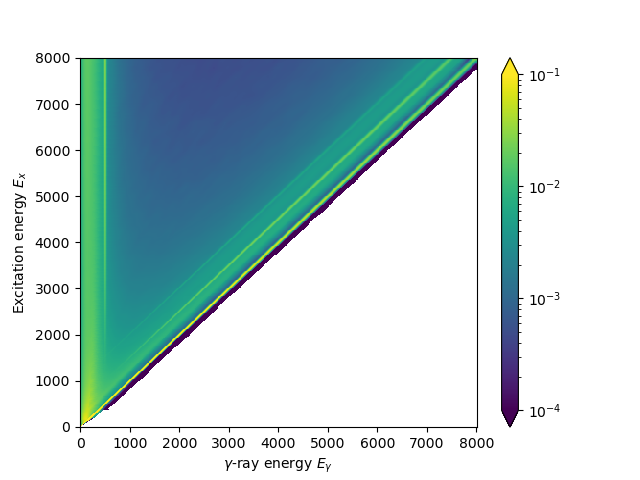

<IPython.core.display.Javascript object>


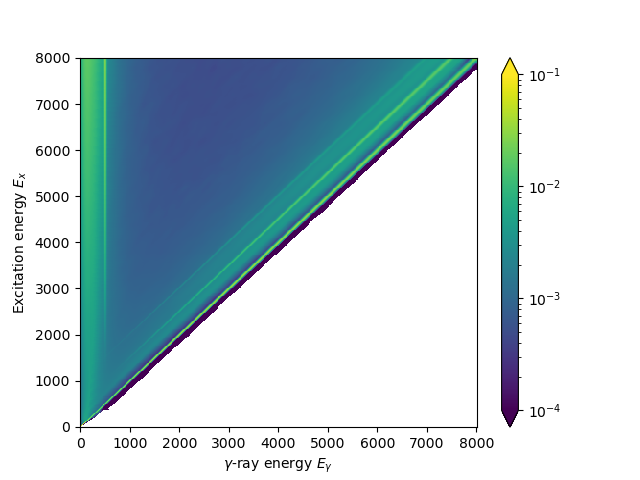

(<matplotlib.collections.QuadMesh at 0x7f80447d2588>,
 <Figure size 640x480 with 2 Axes>)

In [6]:
# generate mock response, where the efficiency is not just 1 per row
R_view.plot(scale="log", vmin=1e-4, vmax=1e-1)
efficiency_mock = np.linspace(0.05, 1, num=R_view.Eg.size)

#alternative choices:
# efficiency_mock = np.linspace(0.9, 1, num=R_view.Eg.size) # just lessen the problem
# efficiency_mock = R_tab_view["eff_tot"] # no change

eff_before = R_tab_view["eff_tot"].copy()
ratio = efficiency_mock/eff_before
R_tab_view["eff_tot"] = efficiency_mock
R_tab_view["pcmp"] *= ratio
R_tab_view["pFE"] *= ratio
R_tab_view["pSE"] *= ratio
R_tab_view["pDE"] *= ratio
R_tab_view["p511"] *= ratio

R_view_effnorm = R_view.copy()
R_view_effnorm.values *= efficiency_mock[:, np.newaxis]
R_view_effnorm.plot(scale="log", vmin=1e-4, vmax=1e-1)

In [7]:
folded = mock_true.copy()
folded.values = mock_true.values @ R_view.values
folded_eff = mock_true.copy()
folded_eff.values = mock_true.values @ R_view_effnorm.values

In [8]:
def py_vector(mat, Emin, Emax):
    py, E = mat.projection("Eg", Emin=Emin, Emax=Emax)
    vec = om.Vector(E=E, values=py)
    return vec

<IPython.core.display.Javascript object>


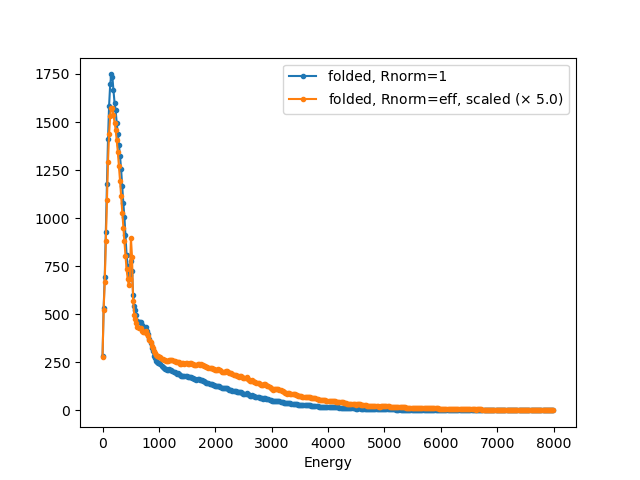

In [9]:
fig, ax = plt.subplots()
folded_py = py_vector(folded, Emin=7000, Emax=7000)
folded_eff_py = py_vector(folded_eff, Emin=7000, Emax=7000)

scaling = 5
folded_py.plot(ax=ax, label="folded, Rnorm=1")
(folded_eff_py*scaling).plot(ax=ax, label=fr"folded, Rnorm=eff, scaled ($\times$ {scaling:.1f})")
ax.legend()

# folded_ = mock_true.copy()
# folded_.values = (mock_true.values/efficiency_mock) @ R_view_effnorm.values
# py, E = folded_.projection("Eg", Emin=7000, Emax=7000)
# folded_ = om.Vector(E=E, values=py)
# (folded_).plot(ax=ax, label=fr"folded, Rnorm=eff, scaled ($\times$ {scaling:.1f})", alpha=0.1)

- Note that the spectra have a different shape now(!), it's not just a scaling difference
- The spectra were the same if one had used `(mock_true.values/efficiency) @ R_view_effnorm.values` -- you can uncomment the line to see the effect.

In [10]:
unfolder = om.Unfolder(response=R_unf)
unfolder.response_tab =  R_tab_unf
# unfolder.weight_fluctuation = 0.001
# unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
#                                      "de": 1.3, "511": 0.9}
# unfolder.remove_negatives = False
unf = unfolder(folded)
unf_eff = unfolder(folded_eff)

<IPython.core.display.Javascript object>


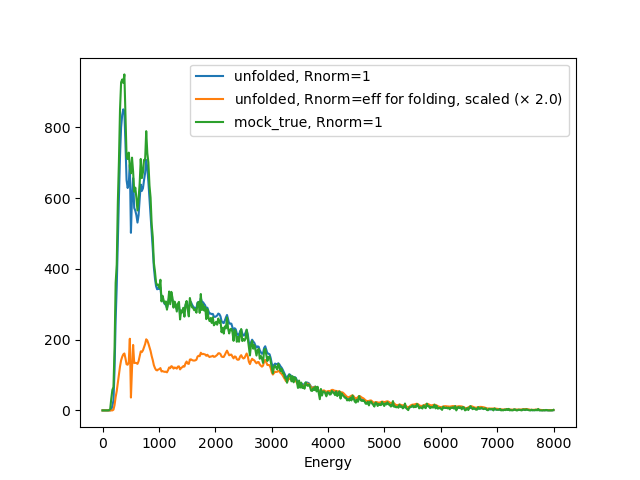

<IPython.core.display.Javascript object>


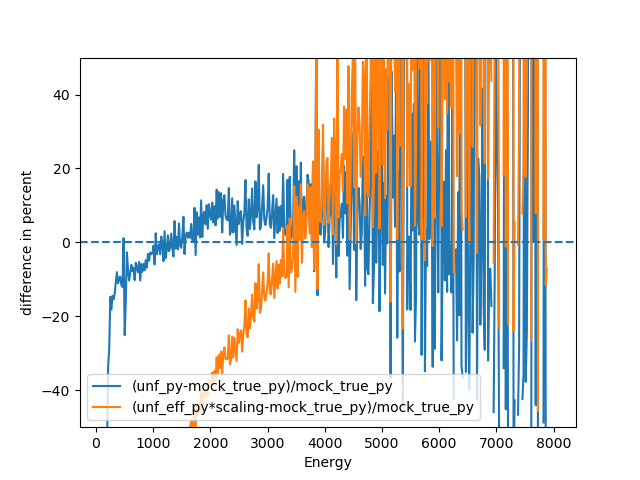

Text(0, 0.5, 'difference in percent')

In [11]:
fig, ax = plt.subplots()
unf_py = py_vector(unf, Emin=7000, Emax=7000)
unf_eff_py = py_vector(unf_eff, Emin=7000, Emax=7000)


scaling = 2
unf_py.plot(ax=ax, markersize=0, label="unfolded, Rnorm=1")
(unf_eff_py*scaling).plot(ax=ax, markersize=0,
                          label=fr"unfolded, Rnorm=eff for folding, scaled ($\times$ {scaling:.1f})")

mock_true_py = py_vector(mock_true, Emin=7000, Emax=7000)
mock_true_py.plot(ax=ax, label="mock_true, Rnorm=1", markersize=0)

ax.legend()

# pøot alspo the differences
fig, ax = plt.subplots()
diff = (unf_py-mock_true_py)/mock_true_py*100
diff.plot(ax=ax, markersize=0, label="(unf_py-mock_true_py)/mock_true_py")

diff = (unf_eff_py*scaling-mock_true_py)/mock_true_py*100
diff.plot(ax=ax, markersize=0, label="(unf_eff_py*scaling-mock_true_py)/mock_true_py")
ax.legend()
ax.axhline(0, ls="--")
ax.set_ylim(-50, 50)
ax.set_ylabel("difference in percent")

Obvious differences between the "true" spectrum, and the unfolded spectrum:

- Even if the same response is used, there is a constant scaling factor for high energies(10%), and variable difference below ~2 MeV.
- If one uses the folded spectrum that is folded with the mock efficiency things get even much worse
- Note that the mock efficiency is chosen to be "worse" (more extreme differences) than what we have for our setup.
- The raw ("true") spectrum never had many counts for Eg<500 keV; if one is interested in the effect for that region, one might set the mock true spectrum eg. to a linear function in that region / use a 252Cf spectrum instead or so